In [57]:
import sys
sys.path.insert(0, 'D:\My Work\Final Year Project\Main\FYP23-Deep-Document-Clustering\Transformer')

In [58]:
import numpy as np
import pandas as pd
import nltk
import os
import warnings
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from nltk.corpus import wordnet as wn, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics import f1_score 
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import torch
import random

from utils.Encoder import Encoder

os.environ['OMP_NUM_THREADS'] = '1'
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.feature_extraction.text")


In [59]:
doc_content = []  # all the content in the document
doc_name = []  # name of the document
files_path = []  # path to the documents
lexical_chain = []  # list of lexical chains from each document
total_features = []  # total number of features. 1652
final_training_Features = []
corpus = []
doc_list_sequence = []

In [60]:
def reset_random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   torch.manual_seed(seed)
   np.random.seed(seed)
   random.seed(seed)


def ReadDocuments(dir_name):
    for Path in os.listdir(dir_name):
        file_p = os.path.join(dir_name, Path)
        with open(file_p, "r") as file:
            FileContents = file.read()
            doc_content.append(FileContents.lower())
            doc_name.append(Path)
            files_path.append(file_p)

def Purity_Score(label_seq, pred_labels):
    # Calculate the confusion matrix to compare true labels and cluster assignments
    confusion = confusion_matrix(label_seq, pred_labels)
    # Calculate the purity
    purity = np.sum(np.max(confusion, axis=0)) / np.sum(confusion)
    return purity

def Evaluate(X, true_labels, predicted_labels):
    purity = Purity_Score(true_labels, predicted_labels)
    silhouette = silhouette_score(X, predicted_labels, metric='euclidean')
    ari = ari_score(true_labels, predicted_labels)
    nmi = nmi_score(true_labels, predicted_labels)
    
    print(f"Purity: {purity}")
    print(f"Silhouette Score: {silhouette}")
    print(f"ARI Score: {ari}")
    print(f"NMI Score: {nmi}")

def SaveFeatures(X, file_name):
    pickle_path = open(file_name, 'wb')
    pickle.dump(X, pickle_path)
    pickle_path.close()

def ReadFeatures(file_name):
    pickle_read = open(file_name, 'rb')
    x = pickle.load(pickle_read)
    pickle_read.close()
    return x

In [61]:
file_name = "DOC50_Features/DOC50_TFIDF_Features.pkl"
x = ReadFeatures(file_name)

In [62]:
x.shape

(50, 3885)

In [63]:
x = x.toarray()

In [64]:
x = torch.tensor(x, dtype=torch.float32)

In [65]:
x = x.reshape(shape=(1, x.size()[0], x.size()[1]))

In [66]:
x.size()

torch.Size([1, 50, 3885])

In [67]:
d_model = 3885
num_heads = 1
drop_prob = 0.1
batch_size = 1
max_sequence_length = 50
ffn_hidden = 2048
num_layers = 5

In [68]:
reset_random_seeds(42)

In [69]:
from utils.PositionalEncoding import PositionalEncoding
pe = PositionalEncoding(d_model=d_model, max_sequence_length=max_sequence_length)
positional_encoding = pe.forward()

In [70]:
positional_encoding = positional_encoding[:,0:-1]

In [71]:
positional_encoding.size()

torch.Size([50, 3885])

In [72]:
x = x + positional_encoding

In [73]:
encoder = Encoder(d_model=d_model, ffn_hidden=ffn_hidden, num_heads=num_heads, drop_prob=drop_prob, num_layers=num_layers)

In [74]:
out = encoder(x)

x.size(): torch.Size([1, 50, 3885])
tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           1.0000e+00,  0.0000e+00],
         [ 8.4147e-01,  5.6684e-01,  8.3891e-01,  ...,  3.3962e-02,
           1.0000e+00,  3.3961e-02],
         [ 9.0930e-01, -4.1615e-01,  9.1319e-01,  ...,  2.0143e-04,
           1.0000e+00,  2.0047e-04],
         ...,
         [ 1.2357e-01, -9.9234e-01,  3.3934e-01,  ...,  4.7335e-03,
           9.9999e-01,  4.7111e-03],
         [-7.6825e-01, -6.4014e-01, -6.0443e-01,  ...,  4.8342e-03,
           9.9999e-01,  4.8114e-03],
         [-9.5375e-01,  3.0059e-01, -9.9730e-01,  ...,  4.9350e-03,
           9.9999e-01,  4.9116e-03]]])
qkv.size(): torch.Size([1, 50, 11655])
1, 50, 1, 3885
qkv.size(): torch.Size([1, 50, 1, 11655])
q.size(): torch.Size([1, 1, 50, 3885]), k.size(): torch.Size([1, 1, 50, 3885]), v.size(): torch.Size([1, 1, 50, 3885])
values.size(): torch.Size([1, 1, 50, 3885]), attention.size(): torch.Size([1, 1, 50, 50])
x.size(): tor

In [75]:
def KMeans_Labels(X, n, rstate_limit, true_labels):
    print(X)
    # Specify the number of clusters (you can choose an appropriate value)
    num_clusters = n
    
    # find centoids which give maximum purity
    purity_collection = {}
    for i in range(rstate_limit):
        clusters = KMeans(n_init='auto', n_clusters=num_clusters, random_state=i, init='k-means++').fit(X).labels_
        purity_collection[i] = Purity_Score(true_labels, clusters)
    
    max_rand_state = max(purity_collection, key=purity_collection.get)
    print(f"Maximum purity of {purity_collection[max_rand_state]} found on random state {max_rand_state}")

    # Create a KMeans model
    kmeans = KMeans(n_init='auto', n_clusters=num_clusters, random_state=max_rand_state, init='k-means++')
    # Fit the KMeans model to the TF-IDF data
    kmeans.fit(X)
    # Get the cluster assignments for each document
    cluster_assignments = kmeans.labels_
    
    return cluster_assignments

def Actual_Labels():
    ReadDocuments(os.getcwd() + "\Doc50")
    actual_labels = {} # dictionary to store true assignments for each document | read sequence not followed
    label_path = os.getcwd() + '\\Doc50 GT\\'
    for labels_directory in os.listdir(label_path): # for each assignment folder
        actual_cluster = int(labels_directory[1]) # extract cluster label from directory name
        doc_labels = os.listdir(label_path + f"\\{labels_directory}") # for all document ids assigned to this cluster
        for doc in doc_labels:
            actual_labels[doc] = actual_cluster-1 # save cluster label
    
    label_seq = [] # save labels in order of documents read
    for doc in doc_name:
        label_seq.append(actual_labels[doc])
    return label_seq

def print_results(true_labels, predicted_labels, X):
    print("RESULTS:")
    print(f"Purity: {Purity_Score(true_labels, predicted_labels)}")
    print(f"Silhouette Score: {silhouette_score(X, predicted_labels)}")


def wrapperFunction():
    # ReadDocuments('Doc50')
    vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', preprocessor=custom_preprocessor)
    X = vectorizer.fit_transform(doc_content)

    SaveFeatures(X, 'DOC50_TFIDF_Features.pkl')
    
    true_labels = Actual_Labels()
    predicted_labels = KMeans_Labels(X, 5, 1500, true_labels)
    Evaluate(X, true_labels, predicted_labels)
    return predicted_labels, X

def plot_graph(x, y):
    plt.scatter(x, y, marker = "o")
    plt.title("Purity x Random State")
    plt.ylabel("Purity")
    plt.xlabel("Random State")
    plt.show()


def calculate_purity(random_state, X, true_labels):
    clusters = KMeans(n_init='auto', n_clusters=num_clusters, random_state=random_state, init='k-means++').fit(X).labels_
    purity = Purity_Score(true_labels, clusters)
    return random_state, purity

def KMeans_Labels_Parallel(X, n, rstate_limit, true_labels):
    # Specify the number of clusters (you can choose an appropriate value)
    global num_clusters
    num_clusters = n
    
    # Use ThreadPoolExecutor to parallelize purity calculations
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(calculate_purity, i, X, true_labels): i for i in range(rstate_limit)}

    purity_collection = {future.result()[0]: future.result()[1] for future in futures}

    max_rand_state = max(purity_collection, key=purity_collection.get)
    print(f"Maximum purity of {purity_collection[max_rand_state]} found on random state {max_rand_state}")

    plot_graph(purity_collection.keys(), purity_collection.values())
    
    # Create a KMeans model
    kmeans = KMeans(n_init='auto', n_clusters=num_clusters, random_state=max_rand_state, init='k-means++')
    # Fit the KMeans model to the data
    kmeans.fit(X)
    # Get the cluster assignments for each data point
    cluster_assignments = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_
    
    return cluster_assignments, cluster_centers 



In [76]:
del encoder

In [77]:
enhanced_x = out.detach().numpy()

In [78]:
enhanced_x[0].shape

(50, 3885)

In [79]:
doc_content = []  # all the content in the document
doc_name = []  # name of the document
files_path = []  # path to the documents
lexical_chain = []  # list of lexical chains from each document
total_features = []  # total number of features. 1652
final_training_Features = []
corpus = []
doc_list_sequence = []

Maximum purity of 1.0 found on random state 653


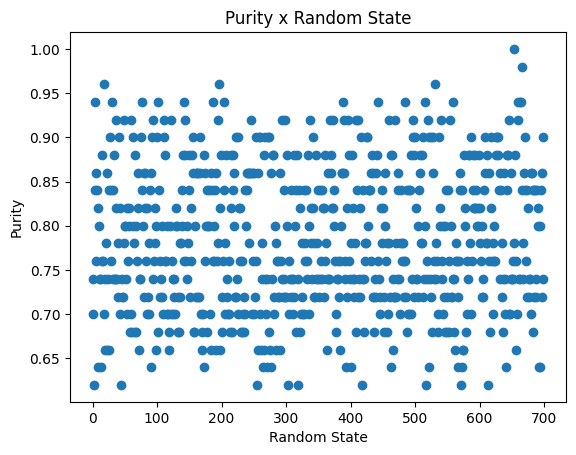

In [80]:
true_labels = Actual_Labels()
pred_lables, centoids = KMeans_Labels_Parallel(enhanced_x[0], 5, 700, true_labels)

In [89]:
kmeans = KMeans(n_init='auto', n_clusters=num_clusters, random_state=653, init='k-means++')
    # Fit the KMeans model to the data
kmeans.fit(enhanced_x[0])
    # Get the cluster assignments for each data point
cluster_assignments = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

In [81]:
Evaluate(enhanced_x[0], true_labels, pred_lables)

Purity: 1.0
Silhouette Score: 0.1671772450208664
ARI Score: 1.0
NMI Score: 1.0


In [82]:
def visualize_clusters(X, cluster_assignments, cluster_centers,num_dimensions=2):
    # Apply PCA to reduce the dimensions for visualization
    pca = PCA(n_components=num_dimensions)
    X_pca = pca.fit_transform(X)

    # Combine data and cluster assignments into a DataFrame
    data_with_clusters = pd.DataFrame(X_pca, columns=[f'PC{i}' for i in range(1, num_dimensions+1)])
    data_with_clusters['Cluster'] = cluster_assignments

    # Scatter plot with different colors for each cluster
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=data_with_clusters, palette='viridis', s=80, alpha=0.8)
    
    # Plot cluster centers if available
    centers = pca.transform(cluster_centers)
    plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label='Cluster Centers')
    
    plt.title('Cluster Visualization (PCA)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()


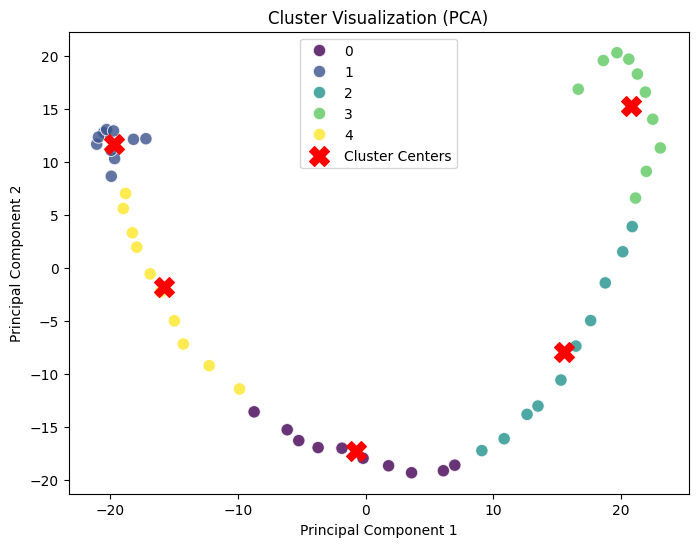

In [83]:
visualize_clusters(enhanced_x[0], pred_lables, cluster_centers=centoids, num_dimensions=2)

In [92]:
np.array(true_labels), pred_lables

(array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3]),
 array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1]))